In [1]:
# Import Basic Python Functionality
import numpy as np
import pandas as pd
import subprocess
from pytube import YouTube
from pydub import AudioSegment
import copy
import random
import datetime
import time
import sys
import re
import os
import io
from os import walk
import scipy.io.wavfile
from scipy import signal
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.dates as mdates
import string
from pathlib import Path


#Import Python Libraries for Machine Learning
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, v_measure_score
from sklearn.preprocessing import MinMaxScaler, normalize, LabelBinarizer, minmax_scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_argmin_min
from sklearn.neighbors import KNeighborsClassifier


# Import Keras/Tensorflow Libraries for Deep Learning
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, add, Lambda
from tensorflow.keras.applications import xception
import tensorflow_addons as tfa  


#GUI Components
from pydub.playback import play
import ipywidgets as widgets
from ipywidgets import interact
from tkinter import * 
from tkinter import ttk
from tkinter.ttk import *
from IPython.display import display
from IPython.display import Image


%matplotlib inline


def vdir(directory): #verify a directory exists, if not make it
    if not os.path.exists(directory): os.mkdir(directory)
    return directory

data_folder=vdir('data')
more_folder=vdir('more')
downloads_folder=vdir(data_folder+'/downloads')
npys_folder=vdir(data_folder+'/npys')
time_series_npys_folder=vdir(npys_folder+'/time_series_audio_npys')    
audio_set_npys_folder=vdir(npys_folder+'/audio_set_npys')

time_series_downloads_folder=vdir(downloads_folder+'/time_series_audio_mp4s') #long time-series mp4 files go in here
audio_set_downloads_folder=vdir(downloads_folder+'/audio_set_mp4s') #short mp4 files from google's AudioSet data go here


Train_from_scratch = True

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#TF_GPU_ALLOCATOR=cuda_malloc_async
print("tf version:",tf.__version__)
print(physical_devices)


2022-06-02 09:26:15.084685: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


tf version: 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Airfield Noise Monitoring with Deep Acoustic Clustering

Continued exposure to aircraft noise is a persistent environmental issue with serious health concerns, including increased reliance on sleep aids and increased risk of heart disease, especially for communities living in close proximity to airfields ([Franssen 2004](https://oem.bmj.com/content/61/5/405); [Torija 2018](https://www.researchgate.net/profile/Antonio-Torija/publication/322328656_Aircraft_classification_for_efficient_modelling_of_environmental_noise_impact_of_aviation/links/5aaabc2845851517881b4434/Aircraft-classification-for-efficient-modelling-of-environmental-noise-impact-of-aviation.pdf)). To protect these communities, noise monitoring around airports remains a cruicial tool ([Asensio 2012](https://www.sciencedirect.com/science/article/abs/pii/S0003682X11002477)). 

Unfortunately, the automated identification of aircraft noise in residential environments can be challenging, due to the confounding presence of additional anthropogenic noise sources ([Tarabini 2014](https://www.sciencedirect.com/science/article/abs/pii/S0003682X1400070X)). To discriminate between these confounding sources, several techniques have been employed including acoustic classification ([Asensio 2010](https://oa.upm.es/7652/2/INVE_MEM_2010_80172.pdf)), noise coincidence with airfield radar tracks ([Timmerman 1991](https://asa.scitation.org/doi/10.1121/1.2029280)), and coincidence with ADS-B tracks ([Giladi 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7481859/pdf/main.pdf)).

In this work, we apply a deep neural network to perform feature extraction and unsupervised clustering on acoustic recordings at an airfield. We then provide a framework for rapidly classifying the clusters via human-machine teaming. Finally, we demonstrate a k-nearest-neighbors algorithm for the automated identification of aircraft noise vs other urban noise sources.

This work represents the first end-to-end discriminative airfield noise monitoring solution that requires only a single microphone with no external knowledge of airfield activities, significantly reducing the barrier to entry for accurate airfield noise monitoring. 

# Time-Series Data

In [2]:
pdict = {}
pdict['r_smp'] = 44100

def pydub_to_np(audio, frame_rate=pdict['r_smp']):
    """
    Converts pydub audio segment into np.float32 of shape [duration_in_seconds*sample_rate, channels],
    where each value is in range [-1.0, 1.0]. 
    Returns tuple (audio_np_array, sample_rate).
    """
    audio.set_frame_rate(frame_rate)
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels)) / (
            1 << (8 * audio.sample_width - 1))

In [3]:
vidLnk = {}
vidLnk['Haneda_Airport'] = "https://www.youtube.com/watch?v=tyD-i1u8f5g"
vidLnk['Chitose_Airport'] = "https://www.youtube.com/watch?v=PxRwSvBeEvA"
vidLnk['Narita_Airport'] = "https://www.youtube.com/watch?v=TGhl84_TUnU"
vidLnk['Houston_Airport'] = "https://www.youtube.com/watch?v=dNTv7g1f5S0"
vidLnk['Funchal_Airport'] = "https://www.youtube.com/watch?v=5RfiTxR9-d8"
outfiles = []

for video_name in vidLnk:
    video_link = vidLnk[video_name]
    video_file = os.path.join(time_series_downloads_folder, video_name+'.mp4')
    audio_file = os.path.join(time_series_npys_folder, video_name+f'_{pdict["r_smp"]}.npy')
    outfiles.append(audio_file)
    print(f'{video_name}:', end='\t')
    
    if not os.path.exists(video_file):
        try:
            print(f'Downloading...', end=' ')
            video = YouTube(video_link)
            audio = video.streams.filter(only_audio=True, file_extension='mp4').first()
            audio.download(filename=video_file)
            print('Complete!', end='\t')
        except:
            print("Error!")  # to handle exception   
    else:
        print('Already Downloaded!', end='\t')            
            
    if (os.path.exists(video_file)) & (not os.path.exists(audio_file)):
        try:
            print(f'Converting...', end=' ')
            seg = AudioSegment.from_file(video_file, format="mp4")
            samples = pydub_to_np(seg, pdict['r_smp'])
            np.save(audio_file, samples)
            print('Complete!', end='\t')
        except:
            print("Error!")  # to handle exception   
    else:
        print("Already Converted!")  
ts_numpy_files = [os.path.join(time_series_npys_folder, f) for f in os.listdir(time_series_npys_folder) if Path(f).suffix == '.npy']



ts_load=ts_numpy_files #[1:3]
bigData=[np.load(f) for f in ts_load]
labelData=[f for f in ts_load]
print(labelData)
print("\nshortest arr in bigData (in s): ",np.min([len(bigData[i])/pdict['r_smp'] for i in range(len(bigData))]))


Haneda_Airport:	Already Downloaded!	Already Converted!
Chitose_Airport:	Already Downloaded!	Already Converted!
Narita_Airport:	Already Downloaded!	Already Converted!
Houston_Airport:	Already Downloaded!	Already Converted!
Funchal_Airport:	Already Downloaded!	Already Converted!
['data/npys/time_series_audio_npys/Funchal_Airport_44100.npy', 'data/npys/time_series_audio_npys/Chitose_Airport_44100.npy', 'data/npys/time_series_audio_npys/Houston_Airport_44100.npy', 'data/npys/time_series_audio_npys/Narita_Airport_44100.npy', 'data/npys/time_series_audio_npys/Haneda_Airport_44100.npy']

shortest arr in bigData (in s):  3675.0686621315194


# Generators 1-4

I rewrote this so now we have a generator inner function that helps shorten gen 1 and 2 (gen 3 and 4 are so different it may not help)

In [ ]:
def generator(data_array,pdict,gen,gen_type_s=True,return_startpoints=False):
    
    nP=pdict['numP']
    nK=pdict['numK']
    window_size_secs=pdict['w_sec']
    shift_size_secs=pdict['s_sec']
    samps_per_second=pdict['r_smp']
    lrb=pdict['LRB']
    
    lr=L_R(lrb)
        
    window_samps=int(window_size_secs*samps_per_second)
    shift_samps=int(shift_size_secs*samps_per_second)
    
    bs=nP*nK #batch size
    
    if gen_type_s:
        v_res=pdict['vres']
        noverlap=v_res/8
        t_len=int((window_samps-noverlap)/(v_res-noverlap))   #These are the time and frequency dimensions of my plot. They come from the scipy spectrogram generation formulas.
        f_len=int(.75 * v_res/2)+1
        
        while 1:
            spectrograms_out, labels, startpoints = gen(data_array,window_samps,shift_samps,samps_per_second,nP,nK,bs,lr,f_len,t_len,v_res)
            if return_startpoints:     
                yield spectrograms_out, labels.astype(int), startpoints
            else:
                yield spectrograms_out, labels.astype(int)
                
def gen1s(data_array,window_samps,shift_samps,samps_per_second,nP,nK,bs,lr,f_len,t_len,v_res): 
    startpoints=[]
    labels=np.zeros(bs)
    spectrograms=np.zeros((bs,f_len,t_len))
    for p in range(nP):
        dind=np.random.randint(len(data_array))
        carr=data_array[dind]   #current array is a random pick between the arrays available in data_array (picking between the different audio files at random basically)
        _df_samps=len(carr)-window_samps-shift_samps   #I moved this up here because it worked much easier since we are working with arrays now instead of a pd table (we don't have to worry about NaNs if we do this instead)
        samp=np.random.randint(_df_samps)
        my_seq=carr[samp:samp+window_samps+shift_samps]   #my_seq is the "region" we will be taking windows from this p

        for k in range(nK):
            batch_idx=p*nK+k  #this is how we organize everything in one long output list. see the graphing cell below for how we can unpack it again
            st_sampx=np.random.randint(shift_samps)
            en_sampx=st_sampx+window_samps

            startpoints.extend([dind,st_sampx+samp])  #I did this wrong before, it used to just be st_sampx but that is a relative value only for within the region we are working in (my_seq) so I had to add the region itself's location to that value to get the true "startpoint" of that region relative to the overall data_array

            labels[batch_idx]=p   #label data for the NN to know which spectrogram is part of which "class"

            x = my_seq[st_sampx:en_sampx,xl(lr)]/(np.max(np.abs(my_seq[st_sampx:en_sampx,xl(lr)]))+1e-8) #Here we are taking a window x at the same time as we normalize and scale it.

            frequencyx, timesx, spectrogramx = signal.spectrogram(x, samps_per_second, nperseg=v_res)
            log_spectrogram=np.log10(spectrogramx[:f_len,:t_len],out=spectrogramx[:f_len,:t_len],where=spectrogramx[:f_len,:t_len] > 0)
            diff=np.max(log_spectrogram)-np.min(log_spectrogram)
            spectrograms[batch_idx]=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)

    return cm.viridis(spectrograms)[:,:,:,0:3], labels, startpoints

In [ ]:
# Generator 1 Parameters
pdict['w_sec'] = 2
pdict['s_sec'] = 0.1
pdict['numP'] = 5
pdict['numK'] = 5
pdict['LRB'] = 'L'   #options are 'L' 'R' or something else. if it's anything other than L or R it will default to using both channels at random
pdict['vres'] = 2**9

test_gen=generator(bigData,pdict,gen1s,return_startpoints=True)
xy,ls,sps=next(test_gen)
print(sps,ls)

nP=pdict['numP']
nK=pdict['numK']

fig, ax = plt.subplots(nP, nK, figsize=(20,nP*2))
for p in range(nP):
    for k in range(nK):
        idx = p*nK +k    
        spectrogram = xy[idx]  #we are doing log10 to scale it so it's nicer to look at
        label = ls[idx]
        ax[p,k].imshow(spectrogram, interpolation='nearest', aspect='auto')
        ax[p,k].set_ylabel('Frequency [Hz]')
        ax[p,k].set_xlabel('Time [sec]')      
    ax[p,0].set_ylabel(label)

In [ ]:
def gen2s(data_array,window_samps,shift_samps,samps_per_second,nP,nK,bs,lr,f_len,t_len,v_res):
    startpoints=[]
    labels=np.zeros(bs)
    spectrograms=np.zeros((bs,f_len,t_len))

    for p in range(nP):
        dind1, dind2 = np.random.randint(len(data_array)), np.random.randint(len(data_array))     #Here I just made 2 of everything
        carr1, carr2 = data_array[dind1], data_array[dind2]                #this makes it so that you combine between random audio files as well as the same audio file. if you just want to pick random regions from the same audio file then get rid of dind 1 and 2 and just do one random dind maybe
        _df_samps1, _df_samps2 = len(carr1)-window_samps-shift_samps, len(carr2)-window_samps-shift_samps   
        samp1, samp2 = np.random.randint(_df_samps1), np.random.randint(_df_samps2)
        my_seq1, my_seq2 = carr1[samp1:samp1+window_samps+shift_samps], carr2[samp2:samp2+window_samps+shift_samps]

        for k in range(nK):
            batch_idx=p*nK+k
            st_samp1, st_samp2 = np.random.randint(shift_samps), np.random.randint(shift_samps)
            en_samp1, en_samp2 = st_samp1+window_samps, st_samp2+window_samps
            startpoints.extend([dind1,st_samp1+samp1,dind2,st_samp2+samp2])  #now every start point is recorded as well so that we have a record of where these segments all came from
            labels[batch_idx]=p         #we see startpoints is now twice as long as before as it contains pairs of parent points now. Labels is the same length as before though so keep this in mind for labelling
            
            s1, s2 = my_seq1[st_samp1:en_samp1,xl(lr)], my_seq2[st_samp2:en_samp2,xl(lr)]
            s = (s1+s2)/((s1+s2).max()+1e-8)

            frequencyx, timesx, spectrogramx = signal.spectrogram(s, samps_per_second, nperseg=v_res)
            log_spectrogram=np.log10(spectrogramx[:f_len,:t_len],out=spectrogramx[:f_len,:t_len],where=spectrogramx[:f_len,:t_len] > 0)
            diff=np.max(log_spectrogram)-np.min(log_spectrogram)
            spectrograms[batch_idx]=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)


    return cm.viridis(spectrograms)[:,:,:,0:3], labels, startpoints

In [ ]:
# Generator 2 Parameters
pdict['w_sec'] = 2
pdict['s_sec'] = 0.1
pdict['numP'] = 5
pdict['numK'] = 4
pdict['LRB'] = 'L'   #options are 'L' 'R' or something else. if it's anything other than L or R it will default to using both channels at random
pdict['vres'] = 2**9

test_gen2=generator(bigData,pdict,gen2s,return_startpoints=True)
spectrograms2,labels2,startpoints2=next(test_gen2)
print(startpoints2,labels2)

nP=pdict['numP']
nK=pdict['numK']

fig, ax = plt.subplots(nP, nK, figsize=(20,nP*2))
for p in range(nP):
    for k in range(nK):
        idx = p*nK +k
        spectrogram = spectrograms2[idx]
        label = labels2[idx]
        ax[p,k].imshow(spectrogram, interpolation='nearest', aspect='auto')
        ax[p,k].set_ylabel('Frequency [Hz]')
        ax[p,k].set_xlabel('Time [sec]')        
    ax[p,0].set_ylabel(label)

In [ ]:
def generator3(data_array, pdict,return_startpoints=False):
    
    nP=pdict['numP']
    nK1=pdict['numK1']
    nK2=pdict['numK2']
    nQ=pdict['numQ']
    window_size_secs=pdict['w_sec']
    shift_size_secs=pdict['s_sec']
    samps_per_second=pdict['r_smp']
    v_res=pdict['vres']
    lrb=pdict['LRB']
    cc=pdict['CC']    # 0-1  combination coefficient, we multiply each q2 window by this factor before adding it to the q1 window
    
    noverlap=v_res/8
    lr=L_R(lrb)
    
    window_samps=int(window_size_secs*samps_per_second)
    shift_samps=int(shift_size_secs*samps_per_second)
    
    t_len=int((window_samps-noverlap)/(v_res-noverlap))  
    f_len=int(.75 * v_res/2)+1
    
    nK=(nK1+(nK2*(nQ-1))) #This represents the total length of a row for counting later.
    bs=(nP*nK1)+(nP*nK2*(nQ-1)) #batch size
    
    while 1:
        
        startpoints=[]
        labels=np.zeros(bs)
        spectrograms=np.zeros((bs,f_len,t_len))

        for p in range(nP):
            
            #Setup random sequences
            dinds,samps,my_seqs=[],[],[]
            for q in range(nQ):
                dinds.append(np.random.randint(len(data_array)))
                carr=data_array[dinds[q]]
                _df_samps=len(carr)-window_samps-shift_samps
                samps.append(np.random.randint(_df_samps))
                my_seqs.append(carr[samps[q]:samps[q]+window_samps+shift_samps])
                
            q1=uniqueness3(my_seqs,lr,4)
            
            
            #Gen1
            for k1 in range(nK1):
                pk1=p*nK+k1
                st_samp = np.random.randint(shift_samps)
                en_samp = st_samp+window_samps
                startpoints.extend([dinds[q1],st_samp+samps[q1]]) 
                labels[pk1]=p
                s = my_seqs[q1][st_samp:en_samp,xl(lr)]/(np.abs(my_seqs[q1][st_samp:en_samp,xl(lr)]).max()+1e-8)
                frequencyx, timesx, spectrogramx = signal.spectrogram(s, samps_per_second, nperseg=v_res)
                #normalize the spectrograms individually here. in imshow it normalizes them between their min and max values so we have to set their min and max to 0 and 1 to get them in the same visual format output from our cmap function at the end
                log_spectrogram=np.log10(spectrogramx[:f_len,:t_len],out=spectrogramx[:f_len,:t_len],where=spectrogramx[:f_len,:t_len] > 0)
                diff=np.max(log_spectrogram)-np.min(log_spectrogram)
                spectrograms[pk1]=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)
        
                
            
            #Gen2
            counter=0  #We are skipping one random index of the q2s overall (q1) so instead of working out a tricky way of using q2 I just made this counter instead.
            for q2 in range(nQ):
                if q2!=q1:
                    for k2 in range(nK2):    
                        qk2=p*nK+nK1+(counter*nK2)+k2  #The first term is just the row, and after that we have to add nK1 (the amount of spectrograms we just added above), and then counter times nQ-1 for which q2 we are on, and then we just add k2
                        st_samp1, st_samp2 = np.random.randint(shift_samps), np.random.randint(shift_samps)
                        en_samp1, en_samp2 = st_samp1+window_samps, st_samp2+window_samps
                        startpoints.extend([dinds[q1],st_samp1+samps[q1]])  #This only saves the startpoints of q1 since we assume the q2 we are adding is noise. If we want to save the q2s as well then maybe we can have a separate startpoints output
                        labels[qk2]=p
                        s1, s2 = my_seqs[q1][st_samp1:en_samp1,xl(lr)], my_seqs[q2][st_samp2:en_samp2,xl(lr)] * cc
                        s = (s1+s2)/(np.abs((s1+s2)).max()+1e-8)
                        frequencyx, timesx, spectrogramx = signal.spectrogram(s, samps_per_second, nperseg=v_res)
                        #normalize the spectrograms individually here. in imshow it normalizes them between their min and max values so we have to set their min and max to 0 and 1 to get them in the same visual format output from our cmap function at the end
                        log_spectrogram=np.log10(spectrogramx[:f_len,:t_len],out=spectrogramx[:f_len,:t_len],where=spectrogramx[:f_len,:t_len] > 0)
                        diff=np.max(log_spectrogram)-np.min(log_spectrogram)
                        spectrograms[qk2]=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)

                    counter+=1
                    
                
 
        spectrograms_out=cm.viridis(spectrograms)[:,:,:,0:3]
        
        if return_startpoints:     
            yield spectrograms_out, labels.astype(int), startpoints
        else:
            yield spectrograms_out, labels.astype(int)

#Uniqueness Functions:
#random
def uniqueness0(sequences):
    q1=np.random.randint(len(sequences))
    #print(q1)
    return q1
    
#intensity
def uniqueness1(sequences):
    maxes=[]
    for seq in sequences:
        maxes.append(np.abs(seq).max())
    q1 = np.array(maxes).argmax() 
    return q1

#variance
def uniqueness2(sequences,lr):
    xlr=xl(lr)  #this assumes the left and right audios have roughly the same variance
    variances=[]
    for seq in sequences:
        variances.append(float(np.var(seq[:,xlr]))*1000)   #ok here's an idea, variance typically measures the spread of our data so if it has high variance then we should choose that maybe?
    q1 = np.abs(np.array(variances)).argmax()
    #print("q1:",q1," variances: ",variances)
    return q1 

#variance in frequency about the peak frequency
def uniqueness3(sequences,lr,n_buff):  #n_buff is the number of buffer frequencies on either side of the peak to give us a variance
    def extract_peak_frequency_variance(data,n_buff):
        ffts = np.fft.fft(data)
        peak_index = np.abs(ffts).argmax()
        if peak_index-n_buff<0:
            peak_freq_spread = ffts[peak_index:peak_index+(2*n_buff)]
        elif peak_index+n_buff>len(ffts):
            peak_freq_spread = ffts[peak_index-(2*n_buff):peak_index]
        else:
            peak_freq_spread = ffts[peak_index-n_buff:peak_index+n_buff]
        return float(np.var(peak_freq_spread))
    xlr=xl(lr)
    peaks=[]
    for seq in sequences:
        tvar=extract_peak_frequency_variance(seq[:,lr],n_buff)
        peaks.append(tvar)
    q1 = np.abs(np.array(peaks)).argmax()        #This is only returning the highest frequency but if we want to classify sounds by specific frequencies this would be useful
    #print("q1:",q1," peak freqs variance: ",peaks)
    return q1 


In [ ]:
# Generator3 Parameters
pdict['w_sec'] = 2
pdict['s_sec'] = 0.1
pdict['numP'] = 5
pdict['numK1'] = 3
pdict['numK2'] = 2
pdict['numQ'] = 4
pdict['LRB'] = 'L'
pdict['vres'] = 2**9
pdict['CC'] = 1/5    #combination coefficient, set this to 1 to see how accurate the uniqueness function is at selecting the most unique segment

test_gen3=generator3(bigData, pdict,return_startpoints=True)
spectrograms3,labels3,startpoints3=next(test_gen3)

nP=pdict['numP']
nK1=pdict['numK1']
nK2=pdict['numK2']
nQ=pdict['numQ']

nK=nK1+(nK2*(nQ-1))   #when doing this in the NN set pdict['nK'] equal to this so we don't have to change the rest of the NN architecture.
fig, ax = plt.subplots(nP, nK, figsize=(20,nP*2))
for p in range(nP):
    for qk in range(nK):
        pqk = p*nK + qk
        spectrogram = spectrograms3[pqk]
        label = labels3[pqk]
        ax[p,qk].imshow(spectrogram, interpolation='nearest', aspect='auto')       
    ax[p,0].set_ylabel('Frequency [Hz]')
    ax[p,nK-1].set_ylabel("p = "+str(label), fontsize=14)
    ax[p,nK-1].yaxis.set_label_position("right")
for k12 in range(nK):
    ax[nP-1,k12].set_xlabel('Time [sec]') 
    if k12<nK1:
        ax[0,k12].set_title("q1")
    else:
        q2i=int((k12-nK1)/nK2)+97 
        ax[0,k12].set_title("q1 + q2["+chr(q2i)+"]/cc",fontsize=13)

In [ ]:
def generator4(data_array, pdict,return_startpoints=False):
    
    nP=pdict['numP']
    nK1=pdict['numK1'] 
    nK2=pdict['numK2']
    nC=pdict['numC']  #1-inf int   combinations number, this is the amount of different windows to add to our q1 for each k2
    cc=pdict['CC']    #0-1 float   combination coefficient, we multiply each c2 window by this before adding it to the c1 window
    window_size_secs=pdict['w_sec']
    shift_size_secs=pdict['s_sec']
    samps_per_second=pdict['r_smp']
    v_res=pdict['vres']
    lrb=pdict['LRB']  #['L','R',something else]
    
    noverlap=v_res/8
    lr=L_R(lrb)
    
    window_samps=int(window_size_secs*samps_per_second)
    shift_samps=int(shift_size_secs*samps_per_second)
    
    t_len=int((window_samps-noverlap)/(v_res-noverlap))   #These are the time and frequency dimensions of my plot. They come from the scipy spectrogram generation formulas.
    f_len=int(.75 * v_res/2)+1

    nK=nK1+nK2 #This represents the total length of a row.
    bs=nP*nK #batch size
        
    while 1:
        
        startpoints=[]
        labels=np.zeros(bs)
        spectrograms=np.zeros((bs,f_len,t_len))

        for p in range(nP):
            
            dind=np.random.randint(len(data_array))
            carr=data_array[dind]
            _df_samps=len(carr)-window_samps-shift_samps
            samp=np.random.randint(_df_samps)
            my_seq=carr[samp:samp+window_samps+shift_samps]
            
            for k in range(nK):   #I shortened and simplified everything so it would fit in one single loop. this is not ideal for programming speed because of the if statement so if it starts slowing anything down just change it to 2 separate loops
                pk=p*nK+k
                st_samp = np.random.randint(shift_samps)
                en_samp = st_samp+window_samps
                startpoints.extend([dind,st_samp+samp]) 
                labels[pk]=p
                xlr=xl(lr)
                if k<nK1:  
                    s = my_seq[st_samp:en_samp,xlr]/(np.abs(my_seq[st_samp:en_samp,xlr]).max()+1e-8)
                else:
                    s = copy.deepcopy(my_seq[st_samp:en_samp,xlr]) #we call a deepcopy so we can just add to s iteratively without affecting dara_array
                    s = s + (cc * np.sum(returnRandomWindows(data_array, window_samps, nC, lr),axis=0)) 
                    s = s/(np.abs(s).max())+1e-8
                    if np.array_equal(s,my_seq[st_samp:en_samp,xlr]):  #This makes sure we really did have a deepcopy and that it remains unchanged in the original array
                        print("ERROR")
                frequencyx, timesx, spectrogramx = signal.spectrogram(s, samps_per_second, nperseg=v_res)
                #normalize the spectrograms individually here. in imshow it normalizes them between their min and max values so we have to set their min and max to 0 and 1 to get them in the same visual format output from our cmap function at the end
                log_spectrogram=np.log10(spectrogramx[:f_len,:t_len],out=spectrogramx[:f_len,:t_len],where=spectrogramx[:f_len,:t_len] > 0)
                diff=np.max(log_spectrogram)-np.min(log_spectrogram)
                spectrograms[pk]=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)
        
 
        spectrograms_out=cm.viridis(spectrograms)[:,:,:,0:3]
        
        if return_startpoints:     
            yield spectrograms_out, labels.astype(int), startpoints
        else:
            yield spectrograms_out, labels.astype(int)

def returnRandomWindows(data_array, window_samps, nC, lr):
    cwinds=[]
    for c in range(nC):
        dindc=np.random.randint(len(data_array))
        carrc=data_array[dindc]
        _df_sampc=len(carrc)-window_samps
        sampc=np.random.randint(_df_sampc)
        cwinds.append(carrc[sampc:sampc+window_samps,xl(lr)])
    return cwinds
            
def xl(lr): 
    return np.random.randint(2) if lr==2 else lr

In [ ]:
# Generator4 Parameters
pdict['w_sec'] = 2
pdict['s_sec'] = 0.1
pdict['numP'] = 5      #Number of different sequences to run the window-shift method inside of overall
pdict['numK1'] = 3     #Number of uncombined output windows
pdict['numK2'] = 4     #Number of combined output windows
pdict['numC'] = 10     #Number of Combinations, i.e. how many random secondary windows do we add to each k2 primary window
pdict['CC'] = 1/200    #Combination Coefficient, multiplies with the secondary windows before they are added to the k2 primary windows
pdict['LRB'] = 'L'   #options are 'L' 'R' or something else. if it's anything other than L or R it will default to using both channels at random
pdict['vres'] = 2**9

test_gen4=generator4(bigData, pdict,return_startpoints=True)
spectrograms4,labels4,startpoints4=next(test_gen4)
#print(startpoints3,labels3)
#print(spectrograms4[0][:,:,0])
#print(spectrograms4[0,:,:,0])

nP=pdict['numP']
nK1=pdict['numK1']
nK2=pdict['numK2']
nC=pdict['numC']

print("Each k2 here is formed just like the k1s but with "+str(nC)+" random windows added to each")
nK=nK1+nK2   #when doing this in the NN set pdict['nK'] equal to this so we don't have to change the rest of the NN architecture.
fig, ax = plt.subplots(nP, nK, figsize=(20,nP*2))
for p in range(nP):
    for k in range(nK):
        pk = p*nK + k
        spectrogram = spectrograms4[pk]
        label = labels4[pk]
        ax[p,k].imshow(spectrogram, interpolation='nearest', aspect='auto')       
    ax[p,0].set_ylabel('Frequency [Hz]')
    ax[p,nK-1].set_ylabel("p = "+str(label), fontsize=14)
    ax[p,nK-1].yaxis.set_label_position("right")
for k12 in range(nK):
    ax[nP-1,k12].set_xlabel('Time [sec]') 
    if k12<nK1:
        ax[0,k12].set_title("k1")
    else:
        ax[0,k12].set_title("k2 "+str(k12-nK1))

# Labeled Data from Google's AudioSet

### <span style="color:red">BEFORE CONTINUING:</span> Make sure to run download.py (takes several hours in background)

Here we similarly convert the 8000 or so youtube mp4s to npys then load up and match them to their respective classes

In [4]:
pdict = {}
pdict['r_smp'] = 44100

video_files=np.sort(os.listdir(audio_set_downloads_folder))
for i,video_file in enumerate(video_files):
    print(int(100*i/len(video_files)),"% converting      ",end='\r')
    video_name=''.join(video_file.split('.')[:-1])
    audio_file = os.path.join(audio_set_npys_folder, video_name+f'_{pdict["r_smp"]}.npy')
    if not os.path.exists(audio_file):
        try:
            seg = AudioSegment.from_file(audio_set_downloads_folder+'/'+video_file, format='mp4')
            samples = pydub_to_np(seg, pdict['r_smp'])
            np.save(audio_file, samples)
        except:
            print("\nError with "+video_name+"\n")  # to handle exception   
print("100 % converted      ")
test_numpy_files = [os.path.join(audio_set_npys_folder, f) for f in os.listdir(audio_set_npys_folder) if Path(f).suffix == '.npy']

100 % converted      


In [5]:
classes = ["Motorboat_speedboat",
"Racecar_autoracing",
"Carpassingby",
"Tiresqueal",
"Caralarm",
"Vehiclehorn_carhorn_honking",
"Airbrake",
"Airhorn_truckhorn",
"Bus",
"Motorcycle",
"Trafficnoise_roadwaynoise",
"Railroadcar_trainwagon",
"Trainwheelssquealing",
"Helicopter",
"Fixed-wingaircraft_airplane",
"Lightengine(highfrequency)",
"Mediumengine(midfrequency)",
"Heavyengine(lowfrequency)"]
len(classes)

18

Let's first import and format the labels.

We weren't able to download some videos so we also need to remove the discrepancies.

Wherever we are missing an physical copy of the file let's pop it from the files and labels lists 

- the reason we have to do this is because we loaded all the labels correctly but they don't correspond exactly to the files in our drive because of skipped downloads. To fix this we line up the files and labels directly from the csv and compare it with our current download directory contents and pop the nonexistent files and labels simultaneously.

I also added in here a tool to measure the lengths of the videos, it will pop any videos under a specified length as well

In [6]:
#Import and format labels and times:
files_labels_times_raw = pd.read_csv('clean_download.csv')[['segment_id','name','time_interval']].to_numpy()
files_raw=[audio_set_npys_folder+'/'+files_labels_times_raw[:,0][i]+'_'+str(pdict['r_smp'])+'.npy' for i in range(len(files_labels_times_raw))] #all the filenames straight from the csv
labels_raw=[files_labels_times_raw[:,1][i][1:-1].replace(' ','').replace("'","").split(',') for i in range(len(files_labels_times_raw))] #preformatting everything so it all fits nicely in python
initial_length=len(files_raw) #this will be used for assertion later
times_raw_str=[files_labels_times_raw[:,2][i].replace(' ','').replace('(','').replace(')','').strip('][').split(',') for i in range(len(files_labels_times_raw))]
times_raw=[[[int(float(tlist[i])*pdict['r_smp']),int(float(tlist[i+1])*pdict['r_smp'])] for i in range(len(tlist)//2)] for tlist in times_raw_str] #times_raw is now preformatted into time in samples

#Pop nonexistent files and their corresponding labels:
if os.path.exists(more_folder+'/pop_arr.npy'): #if we've already done it then just load what we did last time
    pop_arr=np.load(more_folder+'/pop_arr.npy')
    lengths_tmp=np.load(more_folder+'/file_lengths.npy')
    [[files_raw.pop(i), labels_raw.pop(i), times_raw.pop(i)] for i in pop_arr]
else: #goes line by line, if a file is missing from our directory it pops it from files_raw and all our other formatted lists together
    pop_arr=[]
    i,j,count=0,0,0
    while j<len(files_raw):
        if np.sort(test_numpy_files)[i]==files_raw[j]:
            i+=1
            j+=1
        else:
            count+=1
            pop_arr.append(j)
            j+=1
    pop_arr.reverse()
    for popi in pop_arr:
        files_raw.pop(popi)
        labels_raw.pop(popi)
        times_raw.pop(popi)
    assert len(files_raw)==initial_length-count #if this raises an error then something is not in the correct order (check the sorting of files_raw and test_numpy_files)

    #Also pop files under specified video length (in s)
    tmp_data=[np.load(f) for f in files_raw]
    lengths_tmp=[len(tmp_data[i])/pdict['r_smp'] for i in range(len(tmp_data))]
    lengths_under_9s=[i for i,length in enumerate(lengths_tmp) if length<9]; lengths_under_9s.reverse()
    [[files_raw.pop(i), labels_raw.pop(i), times_raw.pop(i),lengths_tmp.pop(i)] for i in lengths_under_9s]
    pop_arr.extend(lengths_under_9s) #the way the indices were popped originally must remain the same order so long story short don't sort this list
    lengths_tmp=[len(np.load(f)) for f in files_raw]
    np.save(more_folder+'/pop_arr.npy',pop_arr)
    np.save(more_folder+'/file_lengths',lengths_tmp)
    del tmp_data

First let's fix the times list so nothing is going to give us an error further down.

In [7]:
#Reformat the times
for i in range(len(times_raw)):
    for j in range(len(times_raw[i])):
        [tmp_ll,tmp_ul]=times_raw[i][j] #upper and lower limits are the event time tags (in samples)
        if tmp_ll>tmp_ul: #if our lower limit is greater than the upper limit
            tmp_ll,tmp_ul=tmp_ul,tmp_ll #flip them
        if tmp_ul>lengths_tmp[i]: #if the true upper limit goes beyond the length of our file
            tmp_ul=lengths_tmp[i] #set it equal to the length of the file
        times_raw[i][j]=[tmp_ll,tmp_ul]

Now some files have multiple labels i.e. maybe a file has both traffic noise and honking sounds. The question becomes how do we tell our generator which files are part of which classes? What we really want is a list of references to files for a given class, i.e. telling the computer to "give me some examples of traffic noise".

To accomplish this I went through and converted our current labels to a truth table where a one corresponds to that class (second index) being a classifier for that file (first index). 

[files,classes]

In [8]:
#Reformat the labels
labels_c=[[classes.index(labels_raw[j][i]) for i in range(len(labels_raw[j]))] for j in range(len(labels_raw))] #write them as class indices instead of strings every time. This is important for our generator later

labels=np.zeros((len(labels_raw),len(classes))) #I did this with labels_raw so it would be easier to show the below demonstration but you could do the same exact thing with labels_c instead
for i,label_list in enumerate(labels_raw):
    for j in range(len(label_list)):
        labels[i,classes.index(label_list[j])]=1
        
print(labels[4],'\n',labels_raw[4],'\n')
print(labels[2],'\n',labels_raw[2],'\n')
print(labels[25],'\n',labels_raw[25],'\n')

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 ['Vehiclehorn_carhorn_honking'] 

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 ['Vehiclehorn_carhorn_honking', 'Vehiclehorn_carhorn_honking'] 

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 
 ['Vehiclehorn_carhorn_honking', 'Trafficnoise_roadwaynoise'] 



Now we want to gather which files are part of what classes (let's call these class groups) and save their file indices to this new array of shape: 

[classes, files_per_class] 

(in reality the number of files per class vary)

In [9]:
#Create class_groups
#This is grouping each "file" into 18 different lists (classes). In this method one "file" may also be in multiple groups (I say "file" because these are really indices of the files_raw array)
class_labels=np.identity(len(classes)) #an array of all the classes in our same format
class_groups=[] #class_groups is a list of lists of each classes common file indices for data_array[index]. for example index 2 and 4 both contain 'Vehiclehorn_carhorn_honking' so we group them together in the same class_group
for i in range(len(class_labels)):
    tmp_group=[]
    for j in range(len(labels)):
        if np.isin(2,class_labels[i]+labels[j]):
            tmp_group.append(j)
    class_groups.append(tmp_group)

length_class_groups=[len(class_groups[i]) for i in range(len(class_groups))]
print("The biggest group is group#:",np.argmax(length_class_groups),' with this many files: ',np.max(length_class_groups))
print("The smallest group is group#:",np.argmin(length_class_groups),' with this many files: ',np.min(length_class_groups))
print('\nHere are the first 10 indices of class_groups[16]:',class_groups[16][0:10],'\nThese are a colleciton of 10 files_raw indices whose files contain audio from class 16: Mediumengine(midfrequency)')

The biggest group is group#: 16  with this many files:  1914
The smallest group is group#: 15  with this many files:  118

Here are the first 10 indices of class_groups[16]: [0, 3, 9, 14, 15, 16, 24, 27, 30, 32] 
These are a colleciton of 10 files_raw indices whose files contain audio from class 16: Mediumengine(midfrequency)


in total, class_groups[16] contains a list of all the files_raw indices that are a part of class 16 (classes[16]="Mediumengine(midfrequency)")

--

Now we define a working set of this data, I defined a lower and upper bound of file indices to pull from files_raw

In [10]:
def fltdc(lb,ub):
    f_=files_raw[lb:ub]
    l_=labels_c[lb:ub]
    t_=times_raw[lb:ub]
    d_=[np.load(f) for f in f_]
    c_=[[i-lb for i in class_groups[j] if i<ub and i>=lb] for j in range(len(class_groups))] #if lb was 0 always then the inner part would just be [i for i in class_groups[j] if i<ub]
    return f_,l_,t_,d_,c_

#Training data set
lb1,ub1=0,1300 #highest ub is len(files_raw)
smallFilenames,smallLabels,smallTimes,smallData,smallClassgroups=fltdc(lb1,ub1)

lengths_tmp=[len(smallData[i])/pdict['r_smp'] for i in range(len(smallData))]
print("shortest arr in smallData (in s): ",np.min(lengths_tmp)) #if this is below your specified length earlier something is wrong
assert np.min(lengths_tmp)>9.0 #if you changed the threshold earlier ignore this

#Test and Validation data sets
l=400 #size of each set

if ub1+l+l<=len(files_raw):
    lb2,ub2=ub1,ub1+l
    lb3,ub3=ub2,ub2+l
else:
    rng=np.random.randint(len(files_raw)-l,size=2)
    lb2,ub2=rng[0],rng[0]+l
    lb3,ub3=rng[1],rng[1]+l
    
smallFilenames2,smallLabels2,smallTimes2,smallData2,smallClassgroups2=fltdc(lb2,ub2)
smallFilenames3,smallLabels3,smallTimes3,smallData3,smallClassgroups3=fltdc(lb3,ub3)


shortest arr in smallData (in s):  9.000181405895692


# Generator C

Uses labelled data and grabs nK random windows from each label or random labels (depending on how big nP is and how small the data set is)

In [11]:
def generatorC(data_array,pdict,sm_labels,sm_times,sm_class_groups,return_startpoints=False): 
    
    nP=pdict['numP']
    nK=pdict['numK']
    window_size_secs=pdict['w_sec']
    samps_per_second=pdict['r_smp']
    v_res=pdict['vres']
    lrb=pdict['LRB']
    noverlap=v_res/8
    lr=L_R(lrb)
    
    window_samps=int(window_size_secs*samps_per_second)
    
    t_len=int((window_samps-noverlap)/(v_res-noverlap))   #These are the time and frequency dimensions of my plot. They come from the scipy spectrogram generation formulas.
    f_len=int(.75 * v_res/2)+1
    
    bs=nP*nK #batch size
    
    skip_n=nP-(len(sm_class_groups)-sm_class_groups.count([]))<=0 #if true we skip the independent picks process and just let repeated labels occur because otherwise we'd have a hard limit of nP=18

    while 1:
        
        startpoints=[]
        labels_gen=[]
        spectrograms=np.zeros((bs,f_len,t_len))
        
        for p in range(nP):
            sm_i,tmp_cgroup=0,[] 
            while tmp_cgroup==[] or (sm_i in labels_gen if skip_n else None): #skip_n is in there incase nP is greater than the 
                sm_i=np.random.randint(len(sm_class_groups))
                tmp_cgroup=sm_class_groups[sm_i] #choose a random non-empty non-repeated segment (the larger rng is the less time this takes)
            #i will be our label and tmp_cgroup will be our data_array indices to randomly pick windows from 
            np.random.shuffle(tmp_cgroup)
            
            #now sm_i is our current class and tmp_cgroup is our current classgroup 
            for k in range(nK):
                batch_idx=p*nK+k
                dind=tmp_cgroup[k] if k<len(tmp_cgroup) else np.random.choice(tmp_cgroup) #we want a random choice of the current classgroup (a random file from that class) but we don't want repeated files if we can avoid it so this is an ordered selection of the random shuffled tmp_cgroup until it runs out of options, then its just a random choice
                carr=data_array[dind]
                
                #Here we choose a window based around our time segment data
                #The way I approached this was to imagine two cases, one where the window is larger than the event time frame and one where the window is shorter than that event time frame
                t_ind=np.random.choice([i for i,smsmlbs in enumerate(sm_labels[dind]) if smsmlbs==sm_i])#randomly chooses a valid labels index where the current class exists in that file
                [ll,ul]=sm_times[dind][t_ind] #lower and upper limits of the event time frame
                
                if ll+window_samps>len(carr): #if the event time frame is smaller than the window and near the end of the file we need to make sure our window doesn't just go right off the end of the file
                    [tl,tu]=np.sort([len(carr)-window_samps,ul-window_samps])
                elif ul-window_samps<0: #if the event time frame is smaller than the window and closeto the beginning of the file we need to make sure our window doesn't precede 0 
                    [tl,tu]=np.sort([ll,0])
                else:
                    [tl,tu]=np.sort([ll,ul-window_samps])#let's take care of 2 possibilities at once, one the window is smaller than the event time frame (if window_samps<ul-ll then we want samp=np.random.randint(ll,ul-window_samps)), and two the window is larger than the event time frame(if window_samps>ul-ll then we want samp=np.random.randint(ul-window_samps,ll))
                samp=np.random.randint(tl,tu) if tl!=tu else tl #if tl==tu then np.random.randint will give an error so we just give it the exception
                window=carr[samp:samp+window_samps,xl(lr)]
                
                n_window=window/(np.max(np.abs(window))+1e-8)

                labels_gen.append(sm_i)
                startpoints.extend([dind,samp])
                
                frequencyx, timesx, spectrogramx = signal.spectrogram(n_window, samps_per_second, nperseg=v_res)
                log_spectrogram=np.log10(spectrogramx[:f_len,:t_len],out=spectrogramx[:f_len,:t_len],where=spectrogramx[:f_len,:t_len] > 0)
                diff=np.max(log_spectrogram)-np.min(log_spectrogram)
                spectrograms[batch_idx]=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)

        spectrograms_out=cm.viridis(spectrograms)[:,:,:,0:3]

        
        if return_startpoints:
            yield spectrograms_out, np.array(labels_gen).astype(int), startpoints
        else:
            yield spectrograms_out, np.array(labels_gen).astype(int)

#Additional Functions:
def xl(lr):
    return np.random.randint(2) if lr==2 else lr
def L_R(lrb):
    return 0 if lrb=='L' else 1 if lrb=='R' else 2

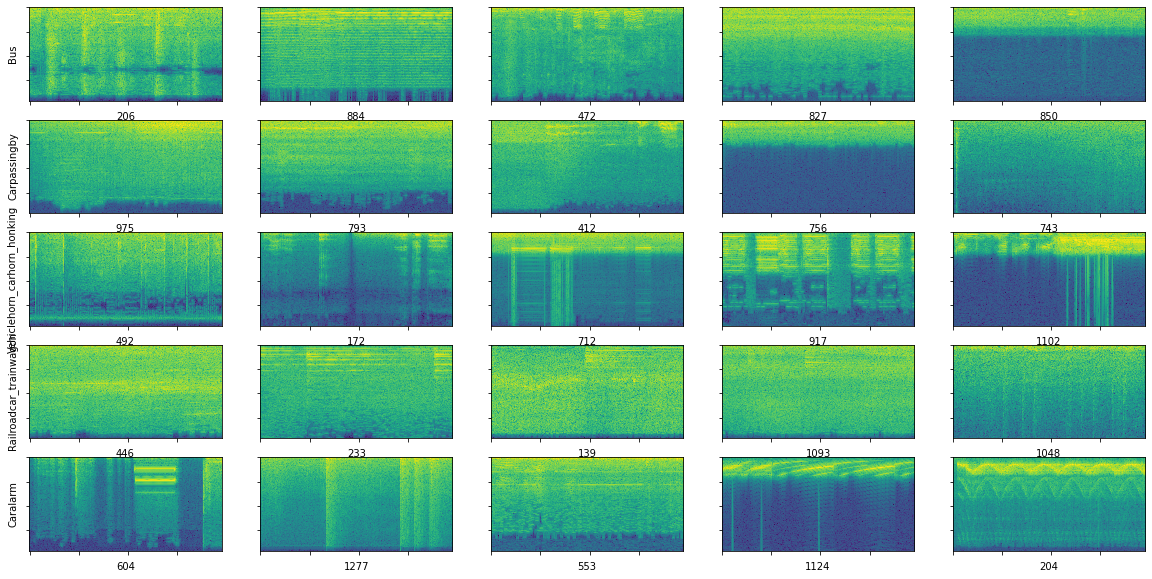

In [12]:
# GeneratorC Parameters
pdict['w_sec'] = 2
pdict['numP'] = 5
pdict['numK'] = 5
pdict['LRB'] = 'L'   #options are 'L' 'R' or something else. if it's anything other than L or R it will default to using both channels at random
pdict['vres'] = 2**9

# Generator instantiation
test_genC=generatorC(smallData,pdict,smallLabels,smallTimes,smallClassgroups,return_startpoints=True)
xy,ls,sps=next(test_genC)
#print(ls)

nP=pdict['numP']
nK=pdict['numK']

fig, ax = plt.subplots(nP, nK, figsize=(20,nP*2))
for p in range(nP):
    for k in range(nK):
        idx = p*nK +k    
        spectrogram = xy[idx]  #we are doing log10 to scale it so it's nicer to look at
        label = ls[idx]
        ax[p,k].imshow(spectrogram, interpolation='nearest', aspect='auto')
        ax[p,k].set_xticklabels([])
        ax[p,k].set_yticklabels([])
        ax[p,k].set_xlabel(str(sps[2*idx]))      
    ax[p,0].set_ylabel(classes[label])

# NN Architecture

In [20]:
def encoder_network(pdict, padding='same'):
    
    nb_channels = pdict['ch']
    dense_layers  = pdict['d']
    out_dim = pdict['od']
    norm = pdict['n']
    img_height = int((int(pdict['w_sec']*pdict['r_smp'])-(pdict['vres']/8))/(pdict['vres']*7/8))
    img_width = int(.75 * pdict['vres']/2)+1

    input_layer = Input(shape=(img_width, img_height, nb_channels))
    base_model = xception.Xception(weights='imagenet',
                              include_top=False,
                              input_shape=(img_width, img_height, nb_channels),
                              pooling='avg')

    x = base_model(input_layer)
    
    for d in dense_layers:
        x = Dense(d, activation='relu')(x)
        
    x = Dense(out_dim, activation='linear', name='output_dense')(x)

    # normalize output for cosine similarity
    if norm:
        x = Lambda(lambda xx: K.l2_normalize(xx, axis=1))(x)

    output_layer = x
    print(f'model.x = {input_layer.shape}')
    print(f'model.y = {output_layer.shape}')
    model = Model(input_layer, output_layer, name='encoder_model')

    return model

In [21]:
def vggish_network(pdict, padding='same'):
    nb_channels = pdict['ch']
    dense_layers  = pdict['d']
    out_dim = pdict['od']
    norm = pdict['n']
    img_height = int((int(pdict['w_sec']*pdict['r_smp'])-(pdict['vres']/8))/(pdict['vres']*7/8))
    img_width = int(.75 * pdict['vres']/2)+1
    
    input_layer = tf.keras.Input(shape=(img_width, img_height, nb_channels), name="img")
    x = tf.keras.layers.Conv2D(64, 3, data_format='channels_last', padding=padding, activation="relu")(input_layer)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(128, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(256, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(512, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.Conv2D(512, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    for d in dense_layers:
        x = Dense(d)(x) #, activation='relu'
        
    # normalize output for cosine similarity
    if norm:
        x = Lambda(lambda xx: K.l2_normalize(xx, axis=1))(x)
    
    output_layer = tf.keras.layers.Dense(out_dim, activation='linear', name='output_dense')(x)
    model = Model(input_layer, output_layer, name="vggish_model")
    
    return model

In [22]:
def load_custom_model(pdict, model_folder='models/'):

    if 'iniW' in pdict.keys():
        print(f'|time:{pdict["iniW"]}')
        model_name = [n for n in os.listdir(model_folder) if f'|time:{pdict["iniW"]}' in n][0][:-3]
        model_file = os.path.join(model_folder, model_name + '.h5')

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        my_acc, my_k = get_acc(pdict)
        my_loss = tfa.losses.TripletSemiHardLoss()
        model = load_model(model_file, custom_objects={'triplet_loss': my_loss, 'tr_acc': my_acc, 's_knn':my_k})
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)

        print('building new model:\n', model_file)
        my_acc, my_k = get_acc(pdict)
        my_loss = tfa.losses.TripletSemiHardLoss()
        model = vggish_network(pdict) if pdict['vggish'] else encoder_network(pdict)

    o = Adam(learning_rate=pdict['lr'], clipnorm=1.)
                      
    model.compile(loss=my_loss, optimizer=o, metrics=[my_acc,my_k])

    return model, model_name


def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    model_filename = os.path.join(model_folder, model_name + '.h5')

    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                         save_weights_only=False, mode='min')
    #print(os.listdir(model_folder)) ####
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                        verbose=0, mode='min', baseline=None)
    tbd = TensorBoard(log_dir=tensor_foldername)
    file_writer = tf.summary.create_file_writer(tensor_foldername + "/metrics")
    file_writer.set_as_default()

    return [sv, stp, tbd]


def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)


def name2param(name):
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key][:-1]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

# Acc Function

In [23]:
def get_pairwise_dists(x, num_p, num_k):
    # pairwise distances for whole batch
    # (redundant computation but probably still faster than alternative)
    norms = tf.reduce_sum(x * x, 1)
    norms = tf.reshape(norms, [-1, 1])
    dists = norms - 2 * tf.matmul(x, x, transpose_b=True) + tf.transpose(norms)
    dists = K.sqrt(K.relu(dists))

    # get the max intra-class distance for each sample
    max_pos = [tf.reduce_max(tf.slice(dists, [i * num_k, i * num_k], [num_k, num_k]), axis=1) for i in range(0, num_p)]
    max_pos = K.concatenate(max_pos, axis=0)

    # get the min inter-class distance for each sample
    min_neg = []
    for i in range(0, num_p):
        left = tf.slice(dists, [i * num_k, 0], [num_k, i * num_k])
        right = tf.slice(dists, [i * num_k, (i + 1) * num_k], [num_k, (num_p - i - 1) * num_k])
        min_neg.append(tf.reduce_min(K.concatenate([left, right], axis=1), axis=1))
    min_neg = K.concatenate(min_neg, axis=0)

    min_max = K.concatenate([K.expand_dims(max_pos, axis=-1), K.expand_dims(min_neg, axis=-1)], axis=1)
    return min_max, dists



def get_triplet_dists(x, margin=0.5):
    x = K.transpose(x)
    max_pos = tf.gather(x, 0)
    min_neg = tf.gather(x, 1)
    # Use relu or softplus
    L_triplet = K.expand_dims(K.softplus(margin + max_pos - min_neg), 1)
    return L_triplet

#slower speed first iteration, all following are the same speed as get_pairwise_dists
def get_pythagorean_pairwise_dists(x,bs): #same operation as pairwise, I was just seeimg some strange results from get_pairwise_dists so I wrote this instead
    diffs=tf.stack([tf.stack([x[j]-x[i] for i in range(bs)]) for j in range(bs)]) #just the geometric differences between vectors i.e. [x1-x2, y1-y2, z1-z2, etc.]
    return tf.sqrt(tf.reduce_sum(diffs**2,axis=2))#differences squared (x1-x2)^2 then summed then the total square rooted by the pythagorean theorem in multiple dimensions

def get_knn_sum(dists, k, bs):
    #Now we want the lowest k distances in a given row not including the identity position
    #I couldnt find a function for the lowest k numbers so I took the top_k of the negative distances which are also the ones closest to 0 then just negate them at the end
    values,indices=tf.math.top_k(-dists,k=k+1) #we take k+1 because the identity (a vector minus itself is 0 and we don't want those so we grab an extra)
    k1_dists=-values
    #Remember to throw out the identity (do k1_dists[:,1:] to get the non-zero entries)
    fa=tf.reduce_sum(k1_dists[:,1:],axis=1) #function a, take the sum or mean of the dists for a row
    fb=tf.reduce_sum(fa) #function b, take the sum or mean of all the distances 
    return fb #, knn_inacc

def get_acc(pdict):
    nP = pdict['numP']
    nK = pdict['numK']
    margin = pdict['m']
    k = nK-1 #I would recommend nK-1 or less unless maybe you want an idea of how close the clustering groups themselves are to one another
    bs=nP*nK
    
    def s_knn(y_true, y_pred):
        dists = get_pythagorean_pairwise_dists(y_pred,bs) #designed for get_pythagorean_pairwise_dists but works with no noticeable difference on get_pairwise_dists, just watch out for those non-zero diagonals
        if tf.shape(dists)!=[]: #workaround for errors on initial empty arrays
            knn_sum = get_knn_sum(dists,k,bs)
            return knn_sum #*tf.cast(inacc+1,tf.float32)
        else:
            return tf.constant([0.0])
    
    def tr_acc(y_true, y_pred):
        min_max, _ = get_pairwise_dists(y_pred, nP, nK)
        loss = get_triplet_dists(min_max, margin)
        pos = K.less(loss, .5)
        return K.mean(pos)

    return tr_acc,s_knn


# Train the Siamese Shift encoder

In [24]:
### OS Parameters
model_folder = vdir('models')
log_folder = vdir('logs')

# Model Parameters
pdict = {}
pdict['vggish'] = True
pdict['pat'] = 10
pdict['d'] = [4096,4096] #[256, 128]
pdict['od'] = 128 #128
pdict['n'] = 1
pdict['ch'] = 3

pdict['lr'] = 0.0001 #default to 0.0001
pdict['m'] = 0.2

# Generator Parameters
pdict['r_smp'] = 44100
pdict['w_sec'] = 1
#pdict['s_sec'] = .6
pdict['vres'] = 2**9
pdict['LRB']='L'
pdict['numP'] = 5


#Generators C,1&2 specific parameter
pdict['numK'] = 5
'''
#Generator 3 specific parameters
pdict['numK1'] = 3
pdict['numK2'] = 2
pdict['numQ'] = 4
pdict['numK'] = pdict['numK1']+(pdict['numK2']*(pdict['numQ']-1))
pdict['CC'] = 1/5

#Generator 4 specific parameters
pdict['numK1'] = 3
pdict['numK2'] = 4
pdict['numK'] = pdict['numK1']+pdict['numK2']
pdict['numC'] = 10
pdict['CC'] = 1/200
'''

# build the generators
gen_trn = generatorC(smallData, pdict, smallLabels, smallTimes, smallClassgroups)
gen_val = generatorC(smallData2, pdict, smallLabels2, smallTimes2, smallClassgroups2)

# load the model
pdict['time'] = int(time.time())
#pdict['iniW'] = 1651599114
model, model_name = load_custom_model(pdict)
model.summary()

# define the steps per epoch
t_len = 10000 #(len(dataTrain)*3)*dataTrain[0].shape[0]/pdict['r_smp']/pdict['w_sec'] #one file divided by window size  (len(dataTrain)/2)*
v_len = t_len/10 #t_len/10
t_step = t_len//(pdict['numP']*pdict['numK'])+1  #t_len over batch size plus one so we never have a t_step of 0
v_step = v_len//(pdict['numP']*pdict['numK'])+1

building new model:
 models/model_type_vggish:True|pat:10|d:4096x4096|od:128|n:1|ch:3|lr:0.0001|m:0.2|r_smp:44100|w_sec:1|vres:512|LRB:L|numP:5|numK:5|time:1654114829
Model: "vggish_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 193, 98, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 193, 98, 64)       1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 49, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 24, 128)      0         
 2D)               

2022-06-01 16:20:29.600214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 16:20:29.897424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9773 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [25]:
## Train the Model
my_hist = model.fit(gen_trn, steps_per_epoch=t_step, epochs=100,
              validation_data=gen_val, validation_steps=v_step,
              callbacks=get_callbacks(model_name, model_folder, log_folder))

Epoch 1/100


2022-06-01 16:20:35.846226: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-01 16:20:36.264228: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-01 16:20:36.264702: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-01 16:20:36.264715: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-06-01 16:20:36.265130: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-01 16:20:36.265162: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-01 16:20:36.795078: I tensorflow/stream_executor/cuda/c

401/401 [==============================] - 24s 45ms/step - loss: 0.6319 - tr_acc: 0.0000e+00 - s_knn: 93.4922 - val_loss: 0.5099 - val_tr_acc: 0.0000e+00 - val_s_knn: 139.1695
Epoch 2/100
233/401 [================>.............] - ETA: 5s - loss: 0.4587 - tr_acc: 0.0000e+00 - s_knn: 184.6145

KeyboardInterrupt: 

# Accuraccy of clusters
We fit a knn-classifier to known data embeddings (train set), then fit new predicted data embeddings (test set) and measure the accuracy of those new predictions


In [26]:
times = [1654113613]
true_accuracies=[]
for timei in times:
    pdict['iniW'] = timei
    model, model_name = load_custom_model(pdict)
    pdict = name2param(model_name)

    # I just used generatorC to get random spectrograms from random groups and we have them all lined up and labelled already
    pdict['numP'] = 18 #must use 18 first go around, because the next generated y_pred2 will have all different classes and if all the classes are not in y_pred then this will make it miss values just because it doesn't know them
    pdict['numK'] = 10
    train_gen=generatorC(smallData,pdict,smallLabels,smallTimes,smallClassgroups)
    o_acc=[]
    for j in range(5):
        spectrograms,ls=next(train_gen)
        shuffled=np.random.permutation(len(ls)) #shuffle everything just incase
        spectrograms=spectrograms[shuffled]
        ls=ls[shuffled]
        y_pred = model.predict(spectrograms)

        k=9
        kclass=KNeighborsClassifier(n_neighbors=k)
        kclass.fit(y_pred,ls)

        acc=[]
        pdict['numP'] = 10
        pdict['numK'] = 10

        test_gen=generatorC(smallData2,pdict,smallLabels2,smallTimes2,smallClassgroups2)
        for i in range(10):
            spectrograms2,ls2=next(test_gen)
            shuffled2=np.random.permutation(len(ls2))
            spectrograms2=spectrograms2[shuffled2]
            ls2=ls2[shuffled2]
            y_pred2 = model.predict(spectrograms2)
            ls2_pred= kclass.predict(y_pred2)
            acc.append((ls2_pred==ls2).mean())
        o_acc.append(np.mean(acc))
        print('Prediction Average Accuracy:',np.mean(acc))#,' std:',np.std(acc))
    print('Overall Accuracy:',np.mean(o_acc))
    true_accuracies.append(np.mean(o_acc))

|time:1654113613
loading previous model:
 models/pat:10|d:2048x2048|od:128|n:1|ch:3|lr:0.0001|m:0.2|r_smp:44100|w_sec:3.5|vres:512|LRB:L|numP:5|numK:5|time:1654113613.h5
4/4 [==============================] - 0s 27ms/step
Prediction Average Accuracy: 0.09
4/4 [==============================] - 0s 27ms/step
Prediction Average Accuracy: 0.10800000000000001
4/4 [==============================] - 0s 26ms/step
Prediction Average Accuracy: 0.092
4/4 [==============================] - 0s 26ms/step
Prediction Average Accuracy: 0.079
4/4 [==============================] - 0s 27ms/step
Prediction Average Accuracy: 0.091
Overall Accuracy: 0.09200000000000001


# Full GUI Cluster Viewer/Namer

In [24]:
GUI_folder=vdir(data_folder+"/GUI")    
images_folder=vdir(GUI_folder+"/images")


# Define the cluster parameters
pdict['iniW'] = 1651772574 #ctime
n_clusters = 50 #total number of clusters we are binning the embeddings into, remember to consider the output dimension (pdict['od']) (not too low a number) and the selection to choose from (not too high a number)
bind=1 #which file from bigData to load
x = bigData[bind][:,0] #The time-series data stream we are going to be splitting into spectrogram windows
nc = 5 #show this many clusters total
n_examples_range = [8,9] #show this many from a given cluster


def get_spectrogram(x, pdict):
    samps_per_second=pdict['r_smp']
    v_res=pdict['vres']    
    noverlap=v_res/8
    window_samps=int(pdict['w_sec']*samps_per_second)
    t_len=int((window_samps-noverlap)/(v_res-noverlap))  
    f_len=int(.75 * v_res/2)+1
    x /= (x.max() + 1e-8)
    _, _, spectrogram = signal.spectrogram(x, samps_per_second, nperseg=v_res)
    #normalize the spectrograms individually here. in imshow it normalizes them between their min and max values so we have to set their min and max to 0 and 1 to get them in the same visual format output from our cmap function at the end
    log_spectrogram=np.log10(spectrogram[:f_len,:t_len],out=spectrogram[:f_len,:t_len],where=spectrogram[:f_len,:t_len] > 0)
    diff=np.max(log_spectrogram)-np.min(log_spectrogram)
    spectrogramf=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)
    spectrogram_out=cm.viridis(spectrogramf)[:,:,0:3]
    
    return spectrogram_out

# Old Image Remover
imageFiles=[os.path.join(images_folder, f) for f in os.listdir(images_folder) if Path(f).suffix == '.png']
for imageFile in imageFiles:
    os.remove(imageFile)             #clears our data/images so we have a clean slate

# Load the model, split the data into spectrogram windows, and predict embeddings for them
model, model_name = load_custom_model(pdict)
pdict = name2param(model_name)
w_len = int(pdict['r_smp']*pdict['w_sec'])
x = np.reshape(x[:-(len(x)%w_len)], (-1, w_len))  #taking the chosen bit of dataTrain and dividing it all into equal sized windows
spectrograms = []
startpoints = []
for i, my_x in enumerate(x):   #i is the index, my_x is the same as x[i]
    spectrograms.append(get_spectrogram(my_x, pdict))    #we are just converting the entire dataTrain into spectrogram windows basically
    startpoints.extend([0,i*len(my_x)])
spectrograms=np.array(spectrograms)
y_pred = model.predict(spectrograms) #the embeddings

# Cluster the embeddings
KM = KMeans(n_clusters)
labels = KM.fit_predict(y_pred)
df = pd.DataFrame(labels, columns=['LABEL'])

#Now make a startpoints (sps) list and print each spectrogram in our cluster to a file
sps=[]
kinp=[]
i=0
my_clusters = np.random.permutation([i for i in range(n_clusters)][:nc])
for c, label in enumerate(my_clusters):
    my_df = df[df.LABEL == label]
    my_np=np.random.permutation(np.array(my_df.index))
    kinp.append(np.random.randint(n_examples_range[0],n_examples_range[1]))
    for e in range(kinp[c]):
        idx = my_np[e] if e<len(my_np) else np.random.choice(my_np)
        #print(my_df.sample(1, replace=True))
        spectrogram = spectrograms[idx]
        sps.extend([bind,startpoints[2*idx+1]])
        path=images_folder+"/"+str(i)+".png"
        scaleF=1
        if kinp[c]>24:
            scaleF=24/kinp[c]
        plt.figure(figsize=(3*scaleF, 2*scaleF))                ###### I made this a scalable feature now but I have only done limited tests on it so far. We have the structure for scaling now though, we just need to change the function to whatever works best as we size up (my guess is something squared)
        plt.tick_params(left=False,right=False,labelleft=False,labelbottom=False,bottom=False)
        plt.xlabel(idx)
        #plt.ylabel('Frequency [Hz]')
        plt.imshow(spectrogram,interpolation='nearest', aspect='auto')
        plt.savefig(path)
        plt.close()
        print(path+" saved")
        i+=1

print(sum(kinp),kinp)
np.save(GUI_folder+'/kinp.npy',kinp)
np.save(GUI_folder+'/startpoints.npy',sps)
np.save(GUI_folder+'/pdict.npy',pdict)

|time:1651772574
loading previous model:
 models/pat:10|d:256x128|od:128|n:1|ch:3|r_smp:44100|w_sec:2|s_sec:0.6|vres:512|w:193|h:196|LRB:L|numP:5|numK:5|lr:0.0001|m:0.2|a:1e-07|time:1651772574.h5
77/77 [==============================] - 2s 24ms/step
data/GUI/images/0.png saved
data/GUI/images/1.png saved
data/GUI/images/2.png saved
data/GUI/images/3.png saved
data/GUI/images/4.png saved
data/GUI/images/5.png saved
data/GUI/images/6.png saved
data/GUI/images/7.png saved
data/GUI/images/8.png saved
data/GUI/images/9.png saved
data/GUI/images/10.png saved
data/GUI/images/11.png saved
data/GUI/images/12.png saved
data/GUI/images/13.png saved
data/GUI/images/14.png saved
data/GUI/images/15.png saved
data/GUI/images/16.png saved
data/GUI/images/17.png saved
data/GUI/images/18.png saved
data/GUI/images/19.png saved
data/GUI/images/20.png saved
data/GUI/images/21.png saved
data/GUI/images/22.png saved
data/GUI/images/23.png saved
data/GUI/images/24.png saved
data/GUI/images/25.png saved
data/G

### Now run the next cell unless you have docker, then just make a new file called GUI.py in the same folder and run it with python3 GUI.py

In [25]:
#GUI.py
#Noise Cluster Viewer (will work for any data, but this version has only been tested with time-series aircraft audios)

import io
import os
import scipy.io.wavfile
from scipy import signal
from pathlib import Path
import numpy as np
from pydub.playback import play
from pydub import AudioSegment
import ipywidgets as widgets
from ipywidgets import interact
from tkinter import *
from tkinter import ttk
from tkinter.ttk import *
from IPython.display import display
from IPython.display import Image
data_folder="data"
npys_folder=data_folder+"/npys/time_series_audio_npys"
GUI_folder=data_folder+"/GUI"
images_folder=GUI_folder+"/images"

numpy_files = [os.path.join(npys_folder, f) for f in os.listdir(npys_folder) if Path(f).suffix == '.npy']
bigData=[np.load(f) for f in numpy_files]
kinp=np.load(GUI_folder+'/kinp.npy')
sps=np.load(GUI_folder+'/startpoints.npy')
pdict=np.load(GUI_folder+'/pdict.npy',allow_pickle=True).item()
#nK=pdict['numK']
w_sec=pdict['w_sec'] #44100*2


def returnAudioSegment(data_array,startpoints,iP,iK,window_size):  #red is a reduction int where say red is 2, this takes every 2nd sample then thus halving the size of the data, the sample rate adjusts accordingly as well
    dind,sind=startpoints[(sum(kinp[:iP])+iK)*2],startpoints[(sum(kinp[:iP])+iK)*2+1]   #replaced iP*nK with sum(kinp[:iP])
    seg=data_array[dind][sind:sind+int(window_size*pdict['r_smp']),iK%2]
    wav_io = io.BytesIO()
    scipy.io.wavfile.write(wav_io, 44100, seg)     #creates a quick audio snippet out of the segment
    wav_io.seek(0)
    return AudioSegment.from_wav(wav_io)  #returns an AudioSegment object for us to work with easily

LARGE_FONT= ("Verdana", 12)
nP=len(kinp)   #We need an nP which is the number of different clusters we want to look at in this case
iP=0           #current cluster
initial=True   #boolean for startup
clusterNames=[str(cni) for cni in range(nP)]

class App(Tk):

    def __init__(self, *args, **kwargs):
        Tk.__init__(self, *args, **kwargs)
        self.title('Cluster Viewer 9000')
        container = Frame(self)
        container.pack(side="top", fill="both", expand = True)
        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)
        self.frames = {}

        for F in (StartPage, ClusteriP):
            frame = F(container, self)
            self.frames[F] = frame
            frame.grid(row=0, column=0, sticky="nsew")

        if initial:
            self.show_frame(StartPage)    #So I had to make it restart everytime on ClusteriP in order for it to refresh to the correct cluster number iP
        else:                             #but this meant we would start the first time on the ClusteriP page so I made this boolean initial to say whether this is the first
            self.show_frame(ClusteriP)    #start or not and set it to false as soon as a StartPage button is pushed

    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()

class StartPage(Frame):          #This viewer is the main screen and shows all the different clusters we can enter to look at

    def __init__(self, parent, controller):
        Frame.__init__(self,parent)
        label = Label(self, text="Start Page", font=LARGE_FONT)
        label.pack(pady=10,padx=10)
        buttonP_dict={}
        for p in range(nP):

            buttonP_dict[p] = Button(self, text="Visit Cluster: "+clusterNames[p],command=lambda p=p:[self.buttonPCallback(p),refresh()])#controller.show_frame(ClusteriP)])
            buttonP_dict[p].pack()

    def buttonPCallback(self,h):
        global iP,initial
        initial=False
        iP=h
        print("Entering Cluster "+str(iP))
class ClusteriP(Frame):           #This frame is our individual cluster viewer and changes depending on which cluster we are entering.

    def __init__(self, parent, controller):
        Frame.__init__(self, parent)
        label = Label(self, text="Cluster: "+str(iP), font=LARGE_FONT)
        label.grid(row=0,column=0)


        def nameCluster(name):
            name = name_C.get()
            global clusterNames
            clusterNames[iP]=name
            print("New Name is: "+name)
        nRow=4                                 #I list everything in columns like this 1 3 5  and nRow is the number of rows (in this example it's 2)
        buttonK_dict={}                        #                                       2 4 6         I did this because window sizes differ a lot so instead of making one standard program window I made it scalable
        self.photoK_dict={}
        audios=[]
        for k in range(kinp[iP]):
            audios.append(returnAudioSegment(bigData,sps,iP,k,w_sec))  #replaced bigData with x
            def buttonKCallback(m=k): #sum(kinp[0:iP])+k): #This is a little clumsy but it works in the loop for now. in StartPage you can see that button callback is a bit more elegantly defined so if we get any errors we may want to do the same with this later
                play(audios[m])
                print("Playing audios: "+str(m))
            self.photoK_dict[k]=PhotoImage(file=images_folder+"/"+str(sum(kinp[0:iP])+k)+".png")      #This will occasionally give an error that it can't find "pyimage304" or something crazy which is something internal to tk.photoimage so I just run another cell calling that method and it works itself out
            buttonK_dict[k] = Button(self, image=self.photoK_dict[k],command=buttonKCallback)
            buttonK_dict[k].grid(row=1+(k%nRow),column=int(k/nRow))
            #print("loaded "+str(sum(kinp[0:w])+k)+".png")
        Label(self, text = 'Name Cluster '+str(iP)+':', font = LARGE_FONT).grid(row=nRow+2,column=0)
        name_C = Entry(self)
        name_C.bind('<Return>',nameCluster)
        name_C.grid(row=nRow+2,column=1)
        homeButton = Button(self, text="Return to Start Page",command=lambda:controller.show_frame(StartPage))
        homeButton.grid(row=nRow+3,column=0)
        nextP=iP+1
        if nextP==nP:
            nextP=0
        nextCButton = Button(self, text="Next Cluster",command=lambda:[StartPage.buttonPCallback(self,nextP),refresh()])
        nextCButton.grid(row=nRow+4,column=0)



def vp_start_gui():
    global app
    app = App()
    app.mainloop()


if __name__ == '__main__':
    def refresh():
        app.destroy()
        vp_start_gui()

    vp_start_gui()

print(clusterNames)





Entering Cluster 0
['0', '1', '2', '3', '4']


# More:

# GUI for checking generator audio

In [35]:
GUI_folder=vdir(data_folder+"/GUI")
gen_images_folder=vdir(GUI_folder+"/gen_images")

# Old Image Remover
imageFiles=[os.path.join(gen_images_folder, f) for f in os.listdir(gen_images_folder) if Path(f).suffix == '.png']
for imageFile in imageFiles:
    os.remove(imageFile)             #clears our data/images so we have a clean slate

# GeneratorC Parameters
pdict['w_sec'] = 2
pdict['numP'] = 18
pdict['numK'] = 10
pdict['LRB'] = 'L'   #options are 'L' 'R' or something else. if it's anything other than L or R it will default to using both channels at random
pdict['vres'] = 2**9

nP,nK=pdict['numP'],pdict['numK']
# Generator instantiation
test_genC=generatorC(smallData,pdict,smallLabels,smallTimes,smallClassgroups,return_startpoints=True)
xy,ls,sps=next(test_genC)
i=0
for p in range(nP):
    for k in range(nK):
        idx = p*nK +k    
        spectrogram = xy[idx]  #we are doing log10 to scale it so it's nicer to look at
        path=gen_images_folder+"/"+str(i)+".png"
        scaleF=1
        if nK>8:
            scaleF=24/(nK*2)
        plt.figure(figsize=(3*scaleF, 2*scaleF))                ###### I made this a scalable feature now but I have only done limited tests on it so far. We have the structure for scaling now though, we just need to change the function to whatever works best as we size up (my guess is something squared)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')   
        plt.imshow(spectrogram,interpolation='nearest', aspect='auto')
        plt.savefig(path)
        plt.close()
        print(path+" saved")
        i+=1

np.save(GUI_folder+'/gen_ls.npy',ls)
np.save(GUI_folder+'/gen_startpoints.npy',sps)
np.save(GUI_folder+'/gen_pdict.npy',pdict)

data/GUI/gen_images/0.png saved
data/GUI/gen_images/1.png saved
data/GUI/gen_images/2.png saved
data/GUI/gen_images/3.png saved
data/GUI/gen_images/4.png saved
data/GUI/gen_images/5.png saved
data/GUI/gen_images/6.png saved
data/GUI/gen_images/7.png saved
data/GUI/gen_images/8.png saved
data/GUI/gen_images/9.png saved
data/GUI/gen_images/10.png saved
data/GUI/gen_images/11.png saved
data/GUI/gen_images/12.png saved
data/GUI/gen_images/13.png saved
data/GUI/gen_images/14.png saved
data/GUI/gen_images/15.png saved
data/GUI/gen_images/16.png saved
data/GUI/gen_images/17.png saved
data/GUI/gen_images/18.png saved
data/GUI/gen_images/19.png saved
data/GUI/gen_images/20.png saved
data/GUI/gen_images/21.png saved
data/GUI/gen_images/22.png saved
data/GUI/gen_images/23.png saved
data/GUI/gen_images/24.png saved
data/GUI/gen_images/25.png saved
data/GUI/gen_images/26.png saved
data/GUI/gen_images/27.png saved
data/GUI/gen_images/28.png saved
data/GUI/gen_images/29.png saved
data/GUI/gen_images/

### run the above code then put the below code in a python file (in the same directory) and run it

In [1]:
#genGUI.py
#Generator Viewer

import io
import os
import scipy.io.wavfile
from scipy import signal
from pathlib import Path
import numpy as np
import pandas as pd
from pydub.playback import play
from pydub import AudioSegment
import ipywidgets as widgets
from ipywidgets import interact
from tkinter import *
from tkinter import ttk
from tkinter.ttk import *
from IPython.display import display
from IPython.display import Image
data_folder="data"
mp4s_folder=data_folder+"/downloads/audio_set_mp4s"
npys_folder=data_folder+"/npys/audio_set_npys"
GUI_folder=data_folder+"/GUI"
images_folder=GUI_folder+"/gen_images"

classes = ["Motorboat_speedboat","Racecar_autoracing","Carpassingby","Tiresqueal","Caralarm","Vehiclehorn_carhorn_honking","Airbrake","Airhorn_truckhorn","Bus","Motorcycle","Trafficnoise_roadwaynoise","Railroadcar_trainwagon","Trainwheelssquealing","Helicopter","Fixed-wingaircraft_airplane","Lightengine(highfrequency)","Mediumengine(midfrequency)","Heavyengine(lowfrequency)"]

ls=np.load(GUI_folder+'/gen_ls.npy')
sps=np.load(GUI_folder+'/gen_startpoints.npy')
pdict=np.load(GUI_folder+'/gen_pdict.npy',allow_pickle=True).item()

files_labels_times_raw = pd.read_csv('clean_download.csv')[['segment_id','name','time_interval']].to_numpy()
files_raw=[npys_folder+'/'+files_labels_times_raw[:,0][i]+'_'+str(pdict['r_smp'])+'.npy' for i in range(len(files_labels_times_raw))]
pop_arr=np.load('more/pop_arr.npy')
[files_raw.pop(i) for i in pop_arr]

lb,ub=0,400
smallFilenames=files_raw[lb:ub]
smallData=[np.load(f) for f in smallFilenames]

w_sec=pdict['w_sec'] #44100*2
kinp=[pdict['numK'] for i in range(pdict['numP'])]
def returnAudioSegment(data_array,startpoints,iP,iK,window_size):  #red is a reduction int where say red is 2, this takes every 2nd sample then thus halving the size of the data, the sample rate adjusts accordingly as well
    dind,sind=startpoints[(sum(kinp[:iP])+iK)*2],startpoints[(sum(kinp[:iP])+iK)*2+1]   #replaced iP*nK with sum(kinp[:iP])
    seg=data_array[dind][sind:sind+int(window_size*pdict['r_smp']),0]
    wav_io = io.BytesIO()
    scipy.io.wavfile.write(wav_io, pdict['r_smp'], seg)     #creates a quick audio snippet out of the segment
    wav_io.seek(0)
    return AudioSegment.from_wav(wav_io)  #returns an AudioSegment object for us to work with easily

LARGE_FONT= ("Verdana", 12)
nP=len(kinp)   #We need an nP which is the number of different clusters we want to look at in this case
iP=0           #current cluster
initial=True   #boolean for startup
clusterNames=[classes[ls[cni*pdict['numK']]] for cni in range(nP)]

class App(Tk):

    def __init__(self, *args, **kwargs):
        Tk.__init__(self, *args, **kwargs)
        self.title('Cluster Viewer 9000')
        container = Frame(self)
        container.pack(side="top", fill="both", expand = True)
        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)
        self.frames = {}

        for F in (StartPage, ClusteriP):
            frame = F(container, self)
            self.frames[F] = frame
            frame.grid(row=0, column=0, sticky="nsew")

        if initial:
            self.show_frame(StartPage)    #So I had to make it restart everytime on ClusteriP in order for it to refresh to the correct cluster number iP
        else:                             #but this meant we would start the first time on the ClusteriP page so I made this boolean initial to say whether this is the first
            self.show_frame(ClusteriP)    #start or not and set it to false as soon as a StartPage button is pushed

    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()

class StartPage(Frame):          #This viewer is the main screen and shows all the different clusters we can enter to look at

    def __init__(self, parent, controller):
        Frame.__init__(self,parent)
        label = Label(self, text="Start Page", font=LARGE_FONT)
        label.pack(pady=10,padx=10)
        buttonP_dict={}
        for p in range(nP):

            buttonP_dict[p] = Button(self, text="Visit Cluster: "+clusterNames[p],command=lambda p=p:[self.buttonPCallback(p),refresh()])#controller.show_frame(ClusteriP)])
            buttonP_dict[p].pack()

    def buttonPCallback(self,h):
        global iP,initial
        initial=False
        iP=h
        print("Entering Cluster "+clusterNames[iP])
class ClusteriP(Frame):           #This frame is our individual cluster viewer and changes depending on which cluster we are entering.

    def __init__(self, parent, controller):
        Frame.__init__(self, parent)
        label = Label(self, text="Cluster: "+clusterNames[iP], font=LARGE_FONT)
        label.grid(row=0,column=0)


        def nameCluster(name):
            name = name_C.get()
            global clusterNames
            clusterNames[iP]=name
            print("New Name is: "+name)
        nRow=4                                 #I list everything in columns like this 1 3 5  and nRow is the number of rows (in this example it's 2)
        buttonK_dict={}                        #                                       2 4 6         I did this because window sizes differ a lot so instead of making one standard program window I made it scalable
        self.photoK_dict={}
        audios=[]
        for k in range(kinp[iP]):
            audios.append(returnAudioSegment(smallData,sps,iP,k,w_sec))  #replaced bigData with x
            def buttonKCallback(m=k): #sum(kinp[0:iP])+k): #This is a little clumsy but it works in the loop for now. in StartPage you can see that button callback is a bit more elegantly defined so if we get any errors we may want to do the same with this later
                print("Playing audio of k= "+str(m))
                #print("k,p=",m,iP)
                #print("dind,sind=",sps[(sum(kinp[:iP])+m)*2],sps[(sum(kinp[:iP])+m)*2+1])
                #print("len of file:",len(smallData[sps[(sum(kinp[:iP])+m)*2]]))
                try:
                    play(audios[m])
                except:
                    print("ffmpeg is having trouble with this one")
                    #play(AudioSegment.from_file(files_raw[sps[(sum(kinp[:iP])+m)*2]], "mp4"))
            self.photoK_dict[k]=PhotoImage(file=images_folder+"/"+str(sum(kinp[0:iP])+k)+".png")      #This will occasionally give an error that it can't find "pyimage304" or something crazy which is something internal to tk.photoimage so I just run another cell calling that method and it works itself out
            buttonK_dict[k] = Button(self, image=self.photoK_dict[k],command=buttonKCallback)
            buttonK_dict[k].grid(row=1+(k%nRow),column=int(k/nRow))
            #print("loaded "+str(sum(kinp[0:w])+k)+".png")
        Label(self, text = 'New Cluster Name:', font = LARGE_FONT).grid(row=nRow+2,column=0)
        name_C = Entry(self)
        name_C.bind('<Return>',nameCluster)
        name_C.grid(row=nRow+2,column=1)
        homeButton = Button(self, text="Return to Start Page",command=lambda:controller.show_frame(StartPage))
        homeButton.grid(row=nRow+3,column=0)
        nextP=iP+1
        if nextP==nP:
            nextP=0
        nextCButton = Button(self, text="Next Cluster",command=lambda:[StartPage.buttonPCallback(self,nextP),refresh()])
        nextCButton.grid(row=nRow+4,column=0)



def vp_start_gui():
    global app
    app = App()
    app.mainloop()


if __name__ == '__main__':
    def refresh():
        app.destroy()
        vp_start_gui()

    vp_start_gui()

print(clusterNames)




Entering Cluster Motorcycle


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpclrdflo6.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp7ze6t70y.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp6j092ykc.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpt0kq7hgf.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmppjqr_kty.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp9m862b0b.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 3
ffmpeg is having trouble with this one
Entering Cluster Airbrake


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpa9azrhw0.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpk39y9e1k.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpj_vmuxzw.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpxbw6nppn.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp68awzg6s.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 0
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpx7psjhdt.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpxeq0yyzx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpnnf1mwr5.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 2
ffmpeg is having trouble with this one
Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp4jz9j3iz.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmppfbrdx8u.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzn3hccyf.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Vehiclehorn_carhorn_honking
Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpa94g5auy.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpwm9kw9bf.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpr1kgmsyp.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp9blwyvdr.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 8
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 3
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2vtwcap0.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp4lqs725o.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpabydm3v3.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp_s0ahsh1.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp8pxgkv43.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpr5bp4ssi.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpi4s5queb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Tiresqueal
Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpkgd70669.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpk68qpl7r.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2c47kce3.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp63mvsxf2.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpyq6aqxjq.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp_afptvn9.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpyztvx9aj.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpg5z_a_5h.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2vwj1f1o.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Motorboat_speedboat
Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpmfi1xgv7.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpadeod2rr.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpdikwuk65.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp87ktrx0z.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Airhorn_truckhorn
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp9vlx3v2s.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp1eoz0tyb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 2
ffmpeg is having trouble with this one
Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp5cqxsscy.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 7
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp_5fi_74n.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Racecar_autoracing
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp80_jro7y.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpz3ez1n4g.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpls59hwr0.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmprkn0y0q_.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpyomi_u68.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpu2kedi14.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Heavyengine(lowfrequency)
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpk6oyurf4.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpiozpndp_.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp1309835o.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmptob0cs58.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Mediumengine(midfrequency)
Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmph7adh9r8.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpq7daymfb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp0185eoe4.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp1lz9dgvs.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s
Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/pytho


Playing audio of k= 6
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpvzkig4f3.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2e875grv.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpcgytrjnx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Caralarm
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpcg5aqxau.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpxoicp96c.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpsp372_p7.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 0
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 8
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Entering Cluster Helicopter
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpy94o6wox.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 7
ffmpeg is having trouble with this one
Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp864u233b.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpkpo7rc1i.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpptr_eyng.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpo_r2fgin.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Trainwheelssquealing
Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpjsgy3pbv.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpp32nutag.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Bus
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpy5hsaouk.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpb_9ah68q.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp05pptfpb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2fi4n4ry.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpqm5gjan9.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzmsjfayl.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 7
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 3
ffmpeg is having trouble with this one
Entering Cluster Lightengine(highfrequency)
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp0687qwkx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzttbx34m.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp09q7nfem.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Fixed-wingaircraft_airplane
Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpa6az72_q.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmprp6532mx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmppepc2_dy.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Trafficnoise_roadwaynoise
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzcv8s6_p.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpoi00quyt.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmplr3ucm8w.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpcnffzcml.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Carpassingby


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 1
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one
Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp7riww0r_.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Railroadcar_trainwagon
['Motorcycle', 'Airbrake', 'Vehiclehorn_carhorn_honking', 'Tiresqueal', 'Motorboat_speedboat', 'Airhorn_truckhorn', 'Racecar_autoracing', 'Heavyengine(lowfrequency)', 'Mediumengine(midfrequency)', 'Caralarm', 'Helicopter', 'Trainwheelssquealing', 'Bus', 'Lightengine(highfrequency)', 'Fixed-wingaircraft_airplane', 'Trafficnoise_roadwaynoise', 'Carpassingby', 'Railroadcar_trainwagon']
